In [29]:
# 04 — Threshold Tuning + Expected Loss + Decision Policy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

scoring = pd.read_csv("xgb_test_scoring.csv")
y_true = scoring["y_true"].astype(int).values
proba  = scoring["proba"].astype(float).values
amount = scoring["amount"].astype(float).values

print("Test size:", len(y_true))
print("Fraud rate:", y_true.mean())

Test size: 56962
Fraud rate: 0.0017204452090867595


In [31]:
# Cost model
# FN cost: missed fraud amount (direct loss proxy)
# FP cost: fixed friction + ops review cost
FP_COST = 10.0

def expected_loss_at_threshold(t, y, p, amt, fp_cost=FP_COST):
    pred = (p >= t).astype(int)
    fp = ((pred == 1) & (y == 0)).sum()
    fn_mask = ((pred == 0) & (y == 1))
    fn = fn_mask.sum()
    fn_cost = amt[fn_mask].sum()
    loss = fp * fp_cost + fn_cost
    return loss, fp, fn, fn_cost

In [33]:
# Sweep thresholds
thresholds = np.linspace(0, 1, 501)
rows = []
for t in thresholds:
    loss, fp, fn, fn_cost = expected_loss_at_threshold(t, y_true, proba, amount)
    rows.append((t, loss, fp, fn, fn_cost))

loss_df = pd.DataFrame(rows, columns=["threshold","expected_loss","fp","fn","fn_cost_amount"])

best = loss_df.loc[loss_df["expected_loss"].idxmin()]
t_flag = float(best["threshold"])
print("Best threshold (t_flag) by expected loss:", t_flag)
print(best)

Best threshold (t_flag) by expected loss: 0.988
threshold            0.988
expected_loss     2000.000
fp                   3.000
fn                  19.000
fn_cost_amount    1970.000
Name: 494, dtype: float64


In [35]:
# Capacity-aware blocking threshold (top-risk tail)
# This reflects that blocking should be reserved for the extreme tail.
block_top_pct = 0.001  # top 0.1% highest risk
t_block = float(np.quantile(proba, 1 - block_top_pct))

print("t_flag:", t_flag)
print("t_block:", t_block)

t_flag: 0.988
t_block: 0.9999264790599999


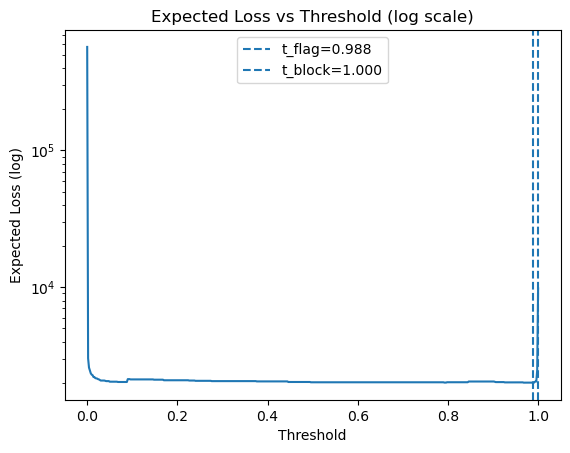

In [37]:
# PLOT A — Expected Loss (log scale) + thresholds
plt.figure()
plt.semilogy(loss_df["threshold"], loss_df["expected_loss"] + 1)  # +1 avoids log(0)
plt.axvline(t_flag, linestyle="--", label=f"t_flag={t_flag:.3f}")
plt.axvline(t_block, linestyle="--", label=f"t_block={t_block:.3f}")
plt.title("Expected Loss vs Threshold (log scale)")
plt.xlabel("Threshold")
plt.ylabel("Expected Loss (log)")
plt.legend()
plt.show()

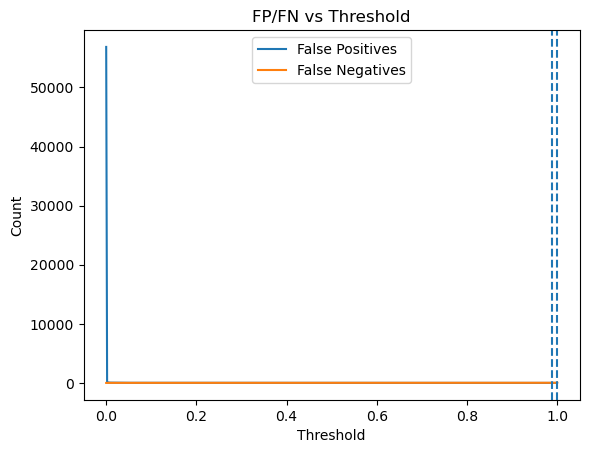

In [39]:
# PLOT B — FP vs FN tradeoff (decision view)
plt.figure()
plt.plot(loss_df["threshold"], loss_df["fp"], label="False Positives")
plt.plot(loss_df["threshold"], loss_df["fn"], label="False Negatives")
plt.axvline(t_flag, linestyle="--")
plt.axvline(t_block, linestyle="--")
plt.title("FP/FN vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("Count")
plt.legend()
plt.show()

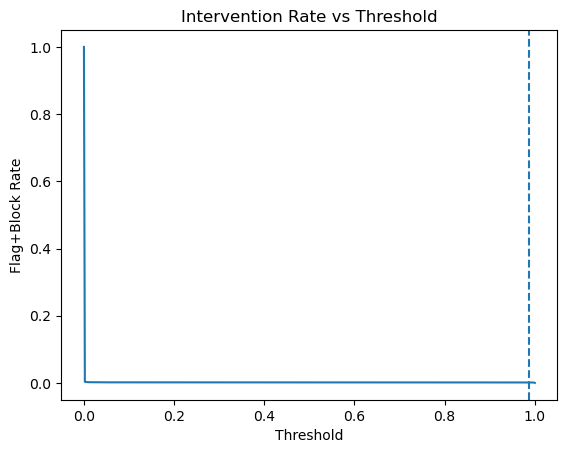

In [41]:
# PLOT C — Intervention rate (ops capacity view)
# Intervention = Flag + Block
# TP at threshold = total_fraud - FN
total_fraud = int(y_true.sum())
loss_df["tp"] = total_fraud - loss_df["fn"]
loss_df["intervention_rate"] = (loss_df["fp"] + loss_df["tp"]) / len(y_true)

plt.figure()
plt.plot(loss_df["threshold"], loss_df["intervention_rate"])
plt.axvline(t_flag, linestyle="--")
plt.title("Intervention Rate vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("Flag+Block Rate")
plt.show()

In [43]:
# Define tiered policy
def assign_action(p, t_flag, t_block):
    # 0=Allow, 1=Flag, 2=Block
    return np.where(p >= t_block, 2, np.where(p >= t_flag, 1, 0))

actions = assign_action(proba, t_flag, t_block)
action_map = {0:"Allow", 1:"Flag", 2:"Block"}

print(pd.Series(actions).map(action_map).value_counts())

Allow    56880
Block       57
Flag        25
Name: count, dtype: int64


In [45]:
# Evaluate policy (Flag+Block treated as intervention)
intervene = (actions >= 1).astype(int)

tp = ((intervene==1) & (y_true==1)).sum()
fp = ((intervene==1) & (y_true==0)).sum()
fn = ((intervene==0) & (y_true==1)).sum()
tn = ((intervene==0) & (y_true==0)).sum()

precision = tp / max(tp + fp, 1)
recall    = tp / max(tp + fn, 1)

fn_cost = amount[(intervene==0) & (y_true==1)].sum()
policy_loss = fp * FP_COST + fn_cost

print("TP:", tp, "FP:", fp, "FN:", fn, "TN:", tn)
print(f"Precision: {precision:.4f} | Recall: {recall:.4f}")
print(f"Expected Loss (policy): {policy_loss:.2f}")

block_mask = (actions == 2)
print("Block count:", int(block_mask.sum()))
if block_mask.sum() > 0:
    print("Block fraud rate:", float(y_true[block_mask].mean()))

print("""
From prediction to decision:
- The model outputs risk scores (probabilities), not final decisions.
- Thresholds are chosen to minimize expected loss and respect capacity constraints.
- This reframes fraud detection as decision optimization, not binary classification.
""")

TP: 79 FP: 3 FN: 19 TN: 56861
Precision: 0.9634 | Recall: 0.8061
Expected Loss (policy): 2000.00
Block count: 57
Block fraud rate: 0.9824561403508771

From prediction to decision:
- The model outputs risk scores (probabilities), not final decisions.
- Thresholds are chosen to minimize expected loss and respect capacity constraints.
- This reframes fraud detection as decision optimization, not binary classification.

